In [ ]:
import numpy as np
import pandas as pd
# import warnings
# warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt 

from IPython.display import HTML

import os

# ai model
import openai
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain_chroma import Chroma
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
# (Error：LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0.
# An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. 
# To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
# LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. 
# An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. 
# To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.)
# chatgpt told me to replace it with `from langchain_openai import OpenAIEmbeddings, ChatOpenAI`
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

from sklearn.metrics import classification_report, confusion_matrix

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

os.environ["OPENAI_API_KEY"] = ''

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\木木小呆猪\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\木木小呆猪\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\木木小呆猪\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\木木小呆猪\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Data Preparation 
Except for the changes to SUMMARY_PATH and SUMMARY_LABELS_PATH, the rest of the code is copied from Mutual fund chat_MF815.ipynb

NLP_app is placed in the same folder as this notebook

In [ ]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

def load_word2vec(filename):
    word2vec = {}
    with open(filename, encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

## data import

In [ ]:
# Get the summaries
SUMMARY_PATH = 'NLP_app/MutualFundSummary' 
fund_names, summaries = get_data(SUMMARY_PATH) 

In [4]:
fund_names

['AB All Market Income Portfolio',
 'AB All Market Real Return Portfolio',
 'AB Arizona Portfolio',
 'AB Asia ex-Japan Equity Portfolio',
 'AB Balanced Wealth Strategy Portfolio',
 'AB Bond Inflation Strategy',
 'AB Credit Long/Short Portfolio',
 'AB Discovery Value Fund',
 'AB Dynamic Asset Allocation Portfolio',
 'AB FlexFee Core Opportunities Portfolio',
 'AB FlexFee Emerging Markets Growth Portfolio',
 'AB FlexFee International Strategic Core Portfolio',
 'AB FlexFee Large Cap Growth Portfolio',
 'AB Global Risk Allocation-Moderate Portfolio',
 'AB Global Thematic Growth Portfolio',
 'AB Income Fund',
 'AB Intermediate Bond Portfolio',
 'AB Limited Duration High Income Portfolio',
 'AB Massachusetts Portfolio',
 'AB Minnesota Portfolio',
 'AB Municipal Bond Inflation Strategy',
 'AB New Jersey Portfolio',
 'AB New York Portfolio',
 'AB Pennsylvania Portfolio',
 'AB Real Estate Investment Portfolio',
 'AB Small Cap Value Portfolio',
 'AB Small/Mid Cap Value Portfolio',
 'AB Tax-Awar

In [6]:
len(fund_names)

545

In [52]:
SUMMARY_LABELS_PATH = 'NLP_app/MutualFundLabels.csv'

df_extraction = pd.DataFrame({'fund_name' : fund_names})
df_label = pd.read_csv(SUMMARY_LABELS_PATH)


In [53]:
df_label.rename({'Ivestment Strategy':'Investment Strategy'}, axis=1, inplace=True)

In [54]:
df_label['Investment Strategy'].value_counts().to_frame()

,count
Investment Strategy,
Equity Long Only (Low Risk),248
Fixed Income Long Only (Low Risk),130
Balanced Fund (Low Risk),84
Long Short Funds (High Risk),4
Commodities Fund (Low Risk),1


In [10]:
df_label

,id,fund_name,Performance fee?,Investment Strategy,Leverage?,Portfolio composition,Concentration
0,0000051931-18-000151,American Funds College 2018 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
1,0000051931-18-000151,American Funds College 2021 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
2,0000051931-18-000151,American Funds College 2024 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
3,0000051931-18-000151,American Funds College 2027 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
4,0000051931-18-000151,American Funds College 2030 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
...,...,...,...,...,...,...,...
462,0001710607-18-000172,American Century Diversified Corporate Bond ETF,NaN,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified
463,0001710607-18-000172,American Century Diversified Municipal Bond ETF,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified
464,0001710607-18-000172,American Century Quality Diversified Internati...,NaN,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified
465,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,NaN,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified


## remove outliers
To avoid interference, delete Long Short Funds (High Risk) and Commodities Fund (Low Risk) directly.

In [8]:
df_label.query("`Investment Strategy` in ['Equity Long Only (Low Risk)','Fixed Income Long Only (Low Risk)','Balanced Fund (Low Risk)']", inplace=True)

# 2 apply RAG using Langchain and OpenAI API to extract mutual fund investment types
references:

Mutual fund chat_4.ipynb

## 2.1Using Langchain and OpenAI API to apply RAG to all fund prospectus in the dataset. 

In [13]:
# Load documents from a directory
loader = DirectoryLoader(path="NLP_app/MutualFundSummary", glob="*.txt")
# Load the text data from the directory
documents = loader.load()

In [ ]:
# openai model
embedding = OpenAIEmbeddings(openai_api_key = os.environ["OPENAI_API_KEY"])
persist_directory = './docs/chroma'

llm_name = "gpt-4o-mini"
print(llm_name)

llm = ChatOpenAI(model_name=llm_name, temperature=0)

r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    separators=["\n\n", "\n", "(?<=\. )", " "]
)

gpt-4o-mini


<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_12564\2277590140.py:14: SyntaxWarning: invalid escape sequence '\.'
  separators=["\n\n", "\n", "(?<=\. )", " "]


In [15]:
df_RAG = pd.DataFrame(fund_names, columns=['fund_name'])
df_RAG['Prediction'] = np.nan
df_RAG['supporting evidence'] = np.nan
df_RAG['source meta data'] = np.nan

In [16]:
df_RAG

,fund_name,Prediction,supporting evidence,source meta data
0,AB All Market Income Portfolio,NaN,NaN,NaN
1,AB All Market Real Return Portfolio,NaN,NaN,NaN
2,AB Arizona Portfolio,NaN,NaN,NaN
3,AB Asia ex-Japan Equity Portfolio,NaN,NaN,NaN
4,AB Balanced Wealth Strategy Portfolio,NaN,NaN,NaN
...,...,...,...,...
540,Virtus Newfleet Dynamic Credit ETF,NaN,NaN,NaN
541,Western Asset Intermediate Maturity California...,NaN,NaN,NaN
542,Western Asset Intermediate Maturity New York M...,NaN,NaN,NaN
543,Western Asset Massachusetts Municipals Fund,NaN,NaN,NaN


## 2.2 Ask the RAG algorithm to classify funds & return supporting evidence. 

In [ ]:
for ii in range(len(df_RAG)):
  print(ii)

  fund_name = df_RAG.iloc[ii]['fund_name']

  print(fund_name)

  splits=r_splitter.split_documents([documents[ii]])

  persist_directory = f"./docs/chroma/{fund_name}"

  vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory=persist_directory
  )

  vectordb.persist()

  # print(len(vectordb))

  # Build prompt
  template = """Classify the fund type from context into 3 categories:
  1 - Equity Long Only (Low Risk)
  2 - Fixed Income Long Only (Low Risk) 
  3 - Balanced Fund (Low Risk)
  If you don't know the answer, just say that you don't know, don't try to make up an answer, and report 0 as a category.
  Respond ONLY with the numeric code and confidence score in this format:
  <number>,<confidence score>

  {context}
  Question: {question}
  Helpful Answer:"""
  QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

  qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
  )

  question = f"Which numeric category (1/2/3) does {fund_name}! belong to?"

  result = qa_chain({"query": question})

  df_RAG.iloc[ii, 1] = result["result"]
  df_RAG.iloc[ii, 2] = result["source_documents"][0].page_content
  df_RAG.iloc[ii, 3] = str(result["source_documents"][0].metadata)


0
AB All Market Income Portfolio


C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_12564\972196464.py:18: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()
C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_12564\972196464.py:45: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain({"query": question})
C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_12564\972196464.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2,0.9' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_RAG.iloc[ii, 1] = result["result"]
C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_12564\972196464.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of panda

1
AB All Market Real Return Portfolio
2
AB Arizona Portfolio
3
AB Asia ex-Japan Equity Portfolio
4
AB Balanced Wealth Strategy Portfolio
5
AB Bond Inflation Strategy
6
AB Credit Long/Short Portfolio
7
AB Discovery Value Fund
8
AB Dynamic Asset Allocation Portfolio
9
AB FlexFee Core Opportunities Portfolio
10
AB FlexFee Emerging Markets Growth Portfolio
11
AB FlexFee International Strategic Core Portfolio
12
AB FlexFee Large Cap Growth Portfolio
13
AB Global Risk Allocation-Moderate Portfolio
14
AB Global Thematic Growth Portfolio
15
AB Income Fund
16
AB Intermediate Bond Portfolio
17
AB Limited Duration High Income Portfolio
18
AB Massachusetts Portfolio
19
AB Minnesota Portfolio
20
AB Municipal Bond Inflation Strategy
21
AB New Jersey Portfolio
22
AB New York Portfolio
23
AB Pennsylvania Portfolio
24
AB Real Estate Investment Portfolio
25
AB Small Cap Value Portfolio
26
AB Small/Mid Cap Value Portfolio
27
AB Tax-Aware Fixed Income Portfolio
28
AB Virginia Portfolio
29
AC ALTERNATIVES 

In [18]:
# about the classification question I asked deepseek:
# template = """Use the following pieces of context to answer the question at the end. Please answer in Yes or No. Give me a confidence score from 1 to 10.
# {context}
# Question: {question}
# Helpful Answer:"""
# QA_CHAIN_PROMPT = PromptTemplate.from_template(template)
# qa_chain = RetrievalQA.from_chain_type(
#   llm,
#   retriever=vectordb.as_retriever(),
#   return_source_documents=True,
#   chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
# )
# question = f"Does Ultra-Short Bond Fund invest in derivatives, such as swaps, options, forwards, futures, put options, and call options? "
# result = qa_chain({"query": question})

# these are the codes for binary classification, now I have 3 categories, how should I change the questions?

In [19]:
df_RAG['Predicted Investment Strategy'] = df_RAG['Prediction'].str[0].astype(int)
df_RAG['Predicted Investment Strategy'].value_counts()

Predicted Investment Strategy
1    266
2    150
3     83
0     46
Name: count, dtype: int64

In [41]:
df_RAG.to_pickle("results/Appendix 1 - RAG result(all).pkl.zip",compression='zip')

In [21]:
df_summary = df_label.merge(df_RAG, on='fund_name', how='inner')

In [22]:
df_summary['Investment Strategy'].replace({'Equity Long Only (Low Risk)': 1,
                                           'Fixed Income Long Only (Low Risk)': 2, 
                                           'Balanced Fund (Low Risk)': 3}, 
                                           inplace=True)
df_summary['Predicted Investment Strategy'].replace(0, np.nan, inplace=True)

C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_12564\4090745938.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_summary['Investment Strategy'].replace({'Equity Long Only (Low Risk)': 1,
C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_12564\4090745938.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

In [23]:
df_summary['Predicted Investment Strategy'].value_counts()

Predicted Investment Strategy
1.0    223
2.0    123
3.0     80
Name: count, dtype: int64

In [24]:
df_summary['Investment Strategy'].value_counts()

Investment Strategy
1    247
2    130
3     84
Name: count, dtype: int64

In [42]:
df_summary.to_pickle("results/Appendix 2 - RAG results(integrated).pkl.zip",compression='zip')

## 2.3 Compare the RAG results with the Investment Strategy labels in “Mutual Fund Labels”.  

In [26]:
pd.set_option('display.max_colwidth', None)
df2 = df_summary.dropna(subset = ['Investment Strategy', 'Predicted Investment Strategy'])

In [27]:
cm = confusion_matrix(df2['Investment Strategy'], df2['Predicted Investment Strategy'])
print(cm)

[[212   1   8]
 [  8 119   0]
 [  3   3  72]]


,Equity Long Only (Low Risk),Fixed Income Long Only (Low Risk),Balanced Fund (Low Risk)
Equity Long Only (Low Risk),212,1,8
Fixed Income Long Only (Low Risk),8,119,0
Balanced Fund (Low Risk),3,3,72


In [50]:
print(classification_report(df2['Investment Strategy'], df2['Predicted Investment Strategy']))

              precision    recall  f1-score   support

           1       0.95      0.96      0.95       221
           2       0.97      0.94      0.95       127
           3       0.90      0.92      0.91        78

    accuracy                           0.95       426
   macro avg       0.94      0.94      0.94       426
weighted avg       0.95      0.95      0.95       426



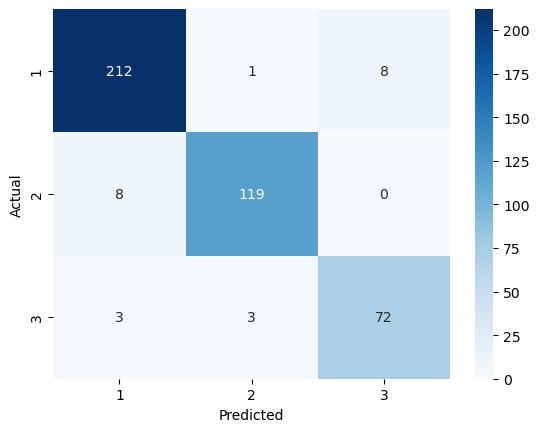

In [47]:
sns.heatmap(pd.DataFrame(cm, index=[1,2,3], columns=[1,2,3]), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 2.4 Pick several funds where the labels from these two sources are not the same. 
Comment on which source is closer to the truth. 

In [33]:
df3 = df2.query("`Investment Strategy` != `Predicted Investment Strategy`")

In [43]:
df3.to_csv("results/Appendix 3 - different classification.csv", index=False)